In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import TimeSeriesSplit,cross_val_score,cross_validate
from sklearn.metrics import mean_absolute_error,mean_squared_log_error,mean_squared_error
from xgboost import XGBRegressor
from statsmodels.tsa.deterministic import DeterministicProcess,CalendarFourier
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder



%matplotlib inline

# Read File

In [2]:
oil = pd.read_csv('oil.csv',parse_dates=['date'],index_col=['date'])
holiday = pd.read_csv('holidays_events.csv',parse_dates=['date'],infer_datetime_format=True)
stores = pd.read_csv('stores.csv')
df_train = pd.read_csv('train.csv',parse_dates=['date'],infer_datetime_format=True)
df_test = pd.read_csv('test.csv',parse_dates=['date'],infer_datetime_format=True)
transaction = pd.read_csv('transactions.csv',parse_dates=['date'],index_col=['date'])

In [3]:
df_all = df_train.append(df_test).reset_index(drop=True)

In [4]:
X_index = df_all.groupby('date').first().index

In [5]:
input_X = pd.DataFrame(index=X_index)

# Creat Features

# a.Fourier

In [6]:
fourier = CalendarFourier(freq ='W',order=4)
dp = DeterministicProcess(order=1,
                         additional_terms=[fourier],
                         constant=False,
                         seasonal=False,
                         index=X_index)
dp.in_sample()

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)","sin(4,freq=W-SUN)","cos(4,freq=W-SUN)"
date,,,,,,,,,
2013-01-01,1.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969
2013-01-02,2.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,0.781831,0.623490
2013-01-03,3.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,-0.974928,-0.222521
2013-01-04,4.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,0.974928,-0.222521
2013-01-05,5.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,-0.781831,0.623490
...,...,...,...,...,...,...,...,...,...
2017-08-27,1696.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,0.433884,-0.900969
2017-08-28,1697.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-08-29,1698.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969


In [7]:
input_X = input_X.merge(dp.in_sample(),on=input_X.index,how='left')
input_X = input_X.rename(columns={'key_0':'date'})

# b.Times

In [8]:
input_X['year'] = input_X.date.dt.year
input_X['month'] = input_X.date.dt.month
input_X['quarter'] = input_X.date.dt.quarter
input_X['day_of_week'] = input_X.date.dt.dayofweek
input_X['day'] = input_X.date.dt.day

# c.Holiday

In [10]:
holiday.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [11]:
holiday.query("type == 'Event'")

,date,type,locale,locale_name,description,transferred
55,2013-05-12,Event,National,Ecuador,Dia de la Madre,False
103,2014-05-11,Event,National,Ecuador,Dia de la Madre,False
106,2014-06-12,Event,National,Ecuador,Inauguracion Mundial de futbol Brasil,False
107,2014-06-15,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Suiza,False
108,2014-06-20,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Honduras,False
113,2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False
114,2014-06-28,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
115,2014-06-29,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
116,2014-06-30,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
117,2014-07-01,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False


In [12]:
holiday[holiday.date == '2014-06-25']

,date,type,locale,locale_name,description,transferred
110,2014-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
111,2014-06-25,Holiday,Local,Machala,Fundacion de Machala,False
112,2014-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
113,2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False


In [13]:
holiday[holiday['date'].duplicated()]

,date,type,locale,locale_name,description,transferred
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False
11,2012-07-03,Holiday,Local,El Carmen,Cantonizacion de El Carmen,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
40,2012-12-31,Additional,National,Ecuador,Primer dia del ano-1,False
55,2013-05-12,Event,National,Ecuador,Dia de la Madre,False
59,2013-06-25,Holiday,Local,Machala,Fundacion de Machala,False
60,2013-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
62,2013-07-03,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False


In [14]:
holiday = holiday.groupby('date').first()

In [16]:
list_event = ['Dia de la Madre','Black Friday','Cyber Monday']
#holiday.loc[holiday.type=='Event','type'] =holiday.description.apply(lambda x:x[0:7])
holiday.loc[holiday.type == 'Event','type'] = holiday.description.apply(lambda x: x if x in list_event else x[0:7])

In [17]:
holiday.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day',
       'Dia de la Madre', 'Inaugur', 'Mundial', 'Black Friday',
       'Cyber Monday', 'Terremo'], dtype=object)

# d.New Stroe

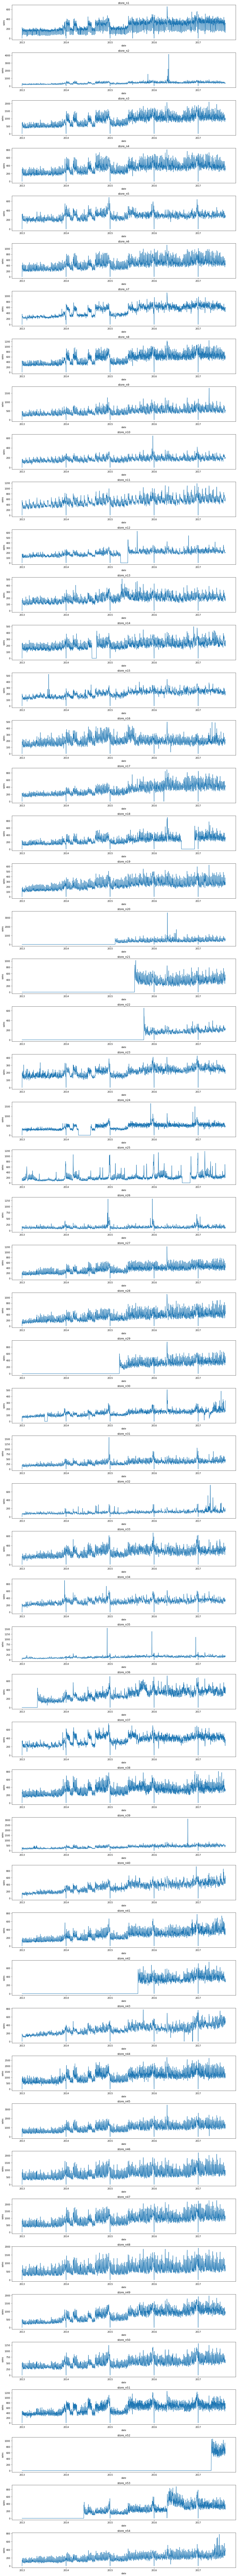

In [21]:
fig,axes = plt.subplots(nrows = 54,ncols=1,figsize=(15,54*3))

for ax,i in zip(axes.flat,np.arange(54)):
    X = df_train.groupby('date')['sales'].mean().index
    Y = df_train[df_train.store_nbr == (i+1)].groupby('date')['sales'].mean()
    sns.lineplot(ax=ax,x=X,y=Y)
    ax.set_title(f'store_n{i+1}')
fig.tight_layout()

In [22]:
new_store = [20,21,22,29,36,42,52,53]
df_all['new_store'] = df_all.store_nbr.apply(lambda x:1 if x in new_store else 0)

In [25]:
one_store = stores.groupby('city')['store_nbr'].nunique().sort_values()[:-8].index.values
stores['only_one_store'] = stores.city.apply(lambda x: 1 if x in one_store else 0)

In [27]:
df_all = df_all.merge(stores,on='store_nbr',how='left')

In [30]:
national = holiday[holiday.locale == 'National']
Local = holiday[holiday.locale == 'Local']
Regional = holiday[holiday.locale == 'Regional']

In [31]:
Local.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False


In [32]:
df_all = df_all.merge(national,on='date',how='left')
df_all = df_all.merge(Local,left_on=['date','city'],right_on=['date','locale_name'],how='left')
df_all = df_all.merge(Regional,left_on=['date','state'],right_on=['date','locale_name'],how='left')
df_all.drop(['locale_x', 'locale_name_x', 'description_x', 'transferred_x','locale_y', 'locale_name_y', 'description_y', 'transferred_y','locale', 'locale_name', 'description', 'transferred'],axis=1,inplace=True)


df_all.columns = ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'new_store', 'city', 'state', 'type_store', 'cluster', 'only_one_store',
       'type_nation', 'type_local', 'type_reg']

In [38]:
df_all.loc[~df_all.type_nation.isna(),'event_type'] = df_all.type_nation.apply(lambda x:x)
df_all.loc[~df_all.type_local.isna(),'event_type'] = df_all.type_local.apply(lambda x:x)
df_all.loc[~df_all.type_reg.isna(),'event_type'] = df_all.type_reg.apply(lambda x:x)

In [39]:
df_all.loc[df_all.event_type.isna(),'event_type'] = 'normal'

In [40]:
df_all['is_event'] = df_all.event_type.apply(lambda x: 0 if x == 'normal' else 1)

In [41]:
df_all.drop(['type_nation','type_local','type_reg'],axis=1,inplace=True)

In [42]:
df_all

,id,date,store_nbr,family,sales,onpromotion,new_store,city,state,type_store,cluster,only_one_store,event_type,is_event
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Quito,Pichincha,D,13,0,Holiday,1
1,1,2013-01-01,1,BABY CARE,0.0,0,0,Quito,Pichincha,D,13,0,Holiday,1
2,2,2013-01-01,1,BEAUTY,0.0,0,0,Quito,Pichincha,D,13,0,Holiday,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,Quito,Pichincha,D,13,0,Holiday,1
4,4,2013-01-01,1,BOOKS,0.0,0,0,Quito,Pichincha,D,13,0,Holiday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,0,Quito,Pichincha,B,6,0,normal,0
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,0,Quito,Pichincha,B,6,0,normal,0
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,0,Quito,Pichincha,B,6,0,normal,0
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,0,Quito,Pichincha,B,6,0,normal,0


In [43]:
input_X

,date,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)","sin(4,freq=W-SUN)","cos(4,freq=W-SUN)",year,month,quarter,day_of_week,day
0,2013-01-01,1.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,2013,1,1,1,1
1,2013-01-02,2.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,0.781831,0.623490,2013,1,1,2,2
2,2013-01-03,3.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,-0.974928,-0.222521,2013,1,1,3,3
3,2013-01-04,4.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,0.974928,-0.222521,2013,1,1,4,4
4,2013-01-05,5.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,-0.781831,0.623490,2013,1,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,2017-08-27,1696.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,0.433884,-0.900969,2017,8,3,6,27
1696,2017-08-28,1697.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2017,8,3,0,28
1697,2017-08-29,1698.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,2017,8,3,1,29
1698,2017-08-30,1699.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,0.781831,0.623490,2017,8,3,2,30


In [44]:
df_all = df_all.merge(input_X,on='date',how='left')

In [45]:
df_all

,id,date,store_nbr,family,sales,onpromotion,new_store,city,state,type_store,...,"cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)","sin(4,freq=W-SUN)","cos(4,freq=W-SUN)",year,month,quarter,day_of_week,day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Quito,Pichincha,D,...,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,2013,1,1,1,1
1,1,2013-01-01,1,BABY CARE,0.0,0,0,Quito,Pichincha,D,...,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,2013,1,1,1,1
2,2,2013-01-01,1,BEAUTY,0.0,0,0,Quito,Pichincha,D,...,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,2013,1,1,1,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,Quito,Pichincha,D,...,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,2013,1,1,1,1
4,4,2013-01-01,1,BOOKS,0.0,0,0,Quito,Pichincha,D,...,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,2013,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,0,Quito,Pichincha,B,...,0.623490,0.974928,-0.222521,-0.974928,-0.222521,2017,8,3,3,31
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,0,Quito,Pichincha,B,...,0.623490,0.974928,-0.222521,-0.974928,-0.222521,2017,8,3,3,31
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,0,Quito,Pichincha,B,...,0.623490,0.974928,-0.222521,-0.974928,-0.222521,2017,8,3,3,31
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,0,Quito,Pichincha,B,...,0.623490,0.974928,-0.222521,-0.974928,-0.222521,2017,8,3,3,31


# e.work_day

In [47]:
df_all['day_of_work'] =False
df_all.loc[df_all.day_of_week <= 4,'day_of_work'] = True
df_all.loc[df_all.event_type == 'Work Day','day_of_work'] = True

In [48]:
df_all['starts_for_school'] = df_all['month'].apply(lambda x :1 if x in [4,5,8,9] else 0)
df_all['weekend'] = df_all['day_of_week'].apply(lambda x :1 if x in [5,6] else 0)
df_all['weekofyear'] = df_all.date.dt.week

# f.Oil

In [50]:
oil_shift = [oil.shift(1),oil.shift(2),oil.shift(3),oil.shift(4)]
for i in oil_shift:
    df_all = df_all.merge(i,on='date',how='left')

In [51]:
df_all.tail()

,id,date,store_nbr,family,sales,onpromotion,new_store,city,state,type_store,...,day_of_week,day,day_of_work,starts_for_school,weekend,weekofyear,dcoilwtico_x,dcoilwtico_y,dcoilwtico_x,dcoilwtico_y
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,0,Quito,Pichincha,B,...,3,31,True,1,0,35,45.96,46.46,46.4,47.65
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,0,Quito,Pichincha,B,...,3,31,True,1,0,35,45.96,46.46,46.4,47.65
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,0,Quito,Pichincha,B,...,3,31,True,1,0,35,45.96,46.46,46.4,47.65
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,0,Quito,Pichincha,B,...,3,31,True,1,0,35,45.96,46.46,46.4,47.65
3029399,3029399,2017-08-31,9,SEAFOOD,NaN,0,0,Quito,Pichincha,B,...,3,31,True,1,0,35,45.96,46.46,46.4,47.65


# 整理完後資料表

In [52]:
df_all

,id,date,store_nbr,family,sales,onpromotion,new_store,city,state,type_store,...,day_of_week,day,day_of_work,starts_for_school,weekend,weekofyear,dcoilwtico_x,dcoilwtico_y,dcoilwtico_x,dcoilwtico_y
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Quito,Pichincha,D,...,1,1,True,0,0,1,NaN,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,0,Quito,Pichincha,D,...,1,1,True,0,0,1,NaN,NaN,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,0,Quito,Pichincha,D,...,1,1,True,0,0,1,NaN,NaN,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,Quito,Pichincha,D,...,1,1,True,0,0,1,NaN,NaN,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,0,Quito,Pichincha,D,...,1,1,True,0,0,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,0,Quito,Pichincha,B,...,3,31,True,1,0,35,45.96,46.46,46.4,47.65
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,0,Quito,Pichincha,B,...,3,31,True,1,0,35,45.96,46.46,46.4,47.65
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,0,Quito,Pichincha,B,...,3,31,True,1,0,35,45.96,46.46,46.4,47.65
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,0,Quito,Pichincha,B,...,3,31,True,1,0,35,45.96,46.46,46.4,47.65


In [53]:
df_all.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'new_store', 'city', 'state', 'type_store', 'cluster', 'only_one_store',
       'event_type', 'is_event', 'trend', 'sin(1,freq=W-SUN)',
       'cos(1,freq=W-SUN)', 'sin(2,freq=W-SUN)', 'cos(2,freq=W-SUN)',
       'sin(3,freq=W-SUN)', 'cos(3,freq=W-SUN)', 'sin(4,freq=W-SUN)',
       'cos(4,freq=W-SUN)', 'year', 'month', 'quarter', 'day_of_week', 'day',
       'day_of_work', 'starts_for_school', 'weekend', 'weekofyear',
       'dcoilwtico_x', 'dcoilwtico_y', 'dcoilwtico_x', 'dcoilwtico_y'],
      dtype='object')

In [54]:
df_all = df_all.fillna(method='backfill')

# 跑模型

In [57]:
X = df_all[['date','new_store','year', 'month', 'quarter', 'day_of_week','day_of_work', 'starts_for_school', 'weekend', 'weekofyear','only_one_store','event_type','is_event','dcoilwtico_x', 'dcoilwtico_y', 'dcoilwtico_x', 'dcoilwtico_y',
        'trend', 'sin(1,freq=W-SUN)','cos(1,freq=W-SUN)', 'sin(2,freq=W-SUN)', 'cos(2,freq=W-SUN)','sin(3,freq=W-SUN)', 'cos(3,freq=W-SUN)', 'sin(4,freq=W-SUN)','cos(4,freq=W-SUN)']]

In [58]:
X = X.groupby('date').first().sort_index()

In [59]:
#one-hot
cols = ['new_store','year','month','quarter','day_of_week','day_of_work','starts_for_school','weekend','weekofyear','only_one_store','event_type','is_event']
for col in cols:
    X =pd.get_dummies(X,columns=[col],drop_first=True)

In [60]:
y = df_all[['date','store_nbr','family','sales']].set_index(['store_nbr','family','date']).sort_index().unstack(['store_nbr','family'])

In [61]:
train_y = y.loc[:'2017-08-15']
test_y = y.loc['2017-08-16':]
train_X = X.loc[:'2017-08-15']
test_X = X.loc['2017-08-16':]

In [62]:
test_X

,dcoilwtico_x,dcoilwtico_x,dcoilwtico_y,dcoilwtico_y,dcoilwtico_x,dcoilwtico_x,dcoilwtico_y,dcoilwtico_y,trend,"sin(1,freq=W-SUN)",...,event_type_Cyber Monday,event_type_Dia de la Madre,event_type_Holiday,event_type_Inaugur,event_type_Mundial,event_type_Terremo,event_type_Transfer,event_type_Work Day,event_type_normal,is_event_1
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,47.57,48.81,47.59,48.54,47.57,48.81,47.59,48.54,1685.0,0.974928,...,0,0,0,0,0,0,0,0,1,0
2017-08-17,46.80,47.59,47.57,48.81,46.80,47.59,47.57,48.81,1686.0,0.433884,...,0,0,0,0,0,0,0,0,1,0
2017-08-18,47.07,47.57,46.80,47.59,47.07,47.57,46.80,47.59,1687.0,-0.433884,...,0,0,0,0,0,0,0,0,1,0
2017-08-19,48.59,46.80,47.07,47.57,48.59,46.80,47.07,47.57,1688.0,-0.974928,...,0,0,0,0,0,0,0,0,1,0
2017-08-20,48.59,46.80,47.07,47.57,48.59,46.80,47.07,47.57,1689.0,-0.781831,...,0,0,0,0,0,0,0,0,1,0
2017-08-21,48.59,46.80,47.07,47.57,48.59,46.80,47.07,47.57,1690.0,0.000000,...,0,0,0,0,0,0,0,0,1,0
2017-08-22,47.39,47.07,48.59,46.80,47.39,47.07,48.59,46.80,1691.0,0.781831,...,0,0,0,0,0,0,0,0,1,0
2017-08-23,47.65,48.59,47.39,47.07,47.65,48.59,47.39,47.07,1692.0,0.974928,...,0,0,0,0,0,0,0,0,1,0
2017-08-24,48.45,47.39,47.65,48.59,48.45,47.39,47.65,48.59,1693.0,0.433884,...,0,0,0,0,0,0,0,0,1,0


In [63]:
test_y

sales                                                \
store_nbr          1                                                  
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-08-16        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-17        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-18        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-19        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-20        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-21        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-22        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-23        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-24        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-25        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-26        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-27        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-28        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-29        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-30        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-31        NaN       NaN    NaN       NaN   NaN          NaN   

                                            ...                                \
store_nbr                                   ...        54                       
family     CELEBRATION CLEANING DAIRY DELI  ... MAGAZINES MEATS PERSONAL CARE   
date                                        ...                                 
2017-08-16         NaN      NaN   NaN  NaN  ...       NaN   NaN           NaN   
2017-08-17         NaN      NaN   NaN  NaN  ...       NaN   NaN           NaN   
2017-08-18         NaN      NaN   NaN  NaN  ...       NaN   NaN           NaN   
2017-08-19         NaN      NaN   NaN  NaN  ...       NaN   NaN           NaN   
2017-08-20         NaN      NaN   NaN  NaN  ...       NaN   NaN           NaN   
2017-08-21         NaN      NaN   NaN  NaN  ...       NaN   NaN           NaN   
2017-08-22         NaN      NaN   NaN  NaN  ...       NaN   NaN           NaN   
2017-08-23         NaN      NaN   NaN  NaN  ...       NaN   NaN           NaN   
2017-08-24         NaN      NaN   NaN  NaN  ...       NaN   NaN           NaN   
2017-08-25         NaN      NaN   NaN  NaN  ...       NaN   NaN           NaN   
2017-08-26         NaN      NaN   NaN  NaN  ...       NaN   NaN           NaN   
2017-08-27         NaN      NaN   NaN  NaN  ...       NaN   NaN           NaN   
2017-08-28         NaN      NaN   NaN  NaN  ...       NaN   NaN           NaN   
2017-08-29         NaN      NaN   NaN  NaN  ...       NaN   NaN           NaN   
2017-08-30         NaN      NaN   NaN  NaN  ...       NaN   NaN           NaN   
2017-08-31         NaN      NaN   NaN  NaN  ...       NaN   NaN           NaN   

                                                                        \
store_nbr                                                                
family     PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY PREPARED FOODS   
date                                                                     
2017-08-16          NaN                     NaN     NaN            NaN   
2017-08-17          NaN                     NaN     NaN            NaN   
2017-08-18          NaN                     NaN     NaN            NaN   
2017-08-19          NaN                     NaN     NaN            NaN   
2017-08-20          NaN                     NaN     NaN            NaN   
2017-08-21          NaN                     NaN     NaN            NaN   
2017-08-22          NaN                     NaN     NaN            NaN   
2017-08-23          NaN                     NaN     NaN            NaN   
2017-08-24          NaN                     NaN     NaN            NaN   
2017-08-25  

# model 1 train趨勢跟算殘差

In [64]:
model_1 = RandomForestRegressor(n_estimators=1000,n_jobs=-1)
model_1.fit(train_X,train_y)

RandomForestRegressor(n_estimators=1000, n_jobs=-1)

In [65]:
predict_y =  pd.DataFrame(model_1.predict(train_X),index=train_X.index,columns=train_y.columns)
predict_y = predict_y.stack(['store_nbr','family']).clip(0).sort_index().reset_index()
train_y_1 = train_y.stack(['store_nbr','family']).sort_index().reset_index()
train_y_1['predict_sales'] = predict_y['sales']

In [66]:
train_y_1['predict_resi'] = train_y_1['sales']-train_y_1['predict_sales']

In [67]:
train_y_1

,date,store_nbr,family,sales,predict_sales,predict_resi
0,2013-01-01,1,AUTOMOTIVE,0.000,0.741000,-0.741000
1,2013-01-01,1,BABY CARE,0.000,0.000000,0.000000
2,2013-01-01,1,BEAUTY,0.000,0.646000,-0.646000
3,2013-01-01,1,BEVERAGES,0.000,373.799000,-373.799000
4,2013-01-01,1,BOOKS,0.000,0.000000,0.000000
...,...,...,...,...,...,...
3000883,2017-08-15,54,POULTRY,59.619,63.572019,-3.953019
3000884,2017-08-15,54,PREPARED FOODS,94.000,91.768000,2.232000
3000885,2017-08-15,54,PRODUCE,915.371,898.416440,16.954560
3000886,2017-08-15,54,SCHOOL AND OFFICE SUPPLIES,0.000,0.215000,-0.215000


In [68]:
train_y_1.groupby('family').apply(lambda x:mean_squared_log_error(x['sales'],x['predict_sales']))

family
AUTOMOTIVE                    0.067991
BABY CARE                     0.007021
BEAUTY                        0.051163
BEVERAGES                     0.310244
BOOKS                         0.003620
BREAD/BAKERY                  0.168928
CELEBRATION                   0.055991
CLEANING                      0.243779
DAIRY                         0.189570
DELI                          0.122482
EGGS                          0.101333
FROZEN FOODS                  0.096359
GROCERY I                     0.393126
GROCERY II                    0.088430
HARDWARE                      0.053327
HOME AND KITCHEN I            0.097974
HOME AND KITCHEN II           0.060846
HOME APPLIANCES               0.023064
HOME CARE                     0.238249
LADIESWEAR                    0.048059
LAWN AND GARDEN               0.065639
LINGERIE                      0.099731
LIQUOR,WINE,BEER              0.359658
MAGAZINES                     0.043109
MEATS                         0.124626
PERSONAL CARE     

In [69]:
train_y_resi = train_y_1.drop(['sales','predict_sales'],axis=1)

In [70]:
train_y_resi = train_y_resi['predict_resi']

In [71]:
train_y_resi

0           -0.741000
1            0.000000
2           -0.646000
3         -373.799000
4            0.000000
              ...    
3000883     -3.953019
3000884      2.232000
3000885     16.954560
3000886     -0.215000
3000887     -1.727000
Name: predict_resi, Length: 3000888, dtype: float64

In [72]:
train_x_resi = df_train[['date','store_nbr','family','onpromotion']].set_index(['date','store_nbr','family']).sort_index()

In [73]:
train_x_resi

onpromotion
date       store_nbr family                                 
2013-01-01 1         AUTOMOTIVE                            0
                     BABY CARE                             0
                     BEAUTY                                0
                     BEVERAGES                             0
                     BOOKS                                 0
...                                                      ...
2017-08-15 54        POULTRY                               0
                     PREPARED FOODS                        0
                     PRODUCE                              76
                     SCHOOL AND OFFICE SUPPLIES            0
                     SEAFOOD                               0

[3000888 rows x 1 columns]

# model 2 train殘差

In [75]:
mode_2 = RandomForestRegressor(n_estimators=1000,n_jobs=-1)
mode_2.fit(train_x_resi,train_y_resi)

RandomForestRegressor(n_estimators=1000, n_jobs=-1)

# model3 combin

In [76]:
test_x_resi = df_test[['date','store_nbr','family','onpromotion']].set_index(['date','store_nbr','family']).sort_index()

In [77]:
test_x_resi

onpromotion
date       store_nbr family                                 
2017-08-16 1         AUTOMOTIVE                            0
                     BABY CARE                             0
                     BEAUTY                                2
                     BEVERAGES                            20
                     BOOKS                                 0
...                                                      ...
2017-08-31 54        POULTRY                               0
                     PREPARED FOODS                        0
                     PRODUCE                               1
                     SCHOOL AND OFFICE SUPPLIES            0
                     SEAFOOD                               0

[28512 rows x 1 columns]

In [78]:
tredn = model_1.predict(test_X)
resi = mode_2.predict(test_x_resi)

In [79]:
predict_trend = pd.DataFrame(tredn,index=test_X.index,columns=train_y.columns)
predict_trend = predict_trend.stack(['store_nbr','family']).clip(0).sort_index().reset_index()
predict_resi = pd.DataFrame(resi,index=test_x_resi.index,columns=['resi']).reset_index()

predict_trend['resi'] = predict_resi['resi']
predict_trend['combin'] = predict_trend['sales']+predict_trend['resi']
predict_trend['combin'] = predict_trend['combin'].clip(0)

In [83]:
predict_trend

,date,store_nbr,family,sales,resi,combin
0,2017-08-16,1,AUTOMOTIVE,5.484000,-0.357212,5.126788
1,2017-08-16,1,BABY CARE,0.000000,-0.357212,0.000000
2,2017-08-16,1,BEAUTY,3.664000,3.385209,7.049209
3,2017-08-16,1,BEVERAGES,2393.496000,9.785977,2403.281977
4,2017-08-16,1,BOOKS,0.200000,-0.357212,0.000000
...,...,...,...,...,...,...
28507,2017-08-31,54,POULTRY,57.647713,-0.357212,57.290501
28508,2017-08-31,54,PREPARED FOODS,72.356000,-0.357212,71.998788
28509,2017-08-31,54,PRODUCE,510.100751,1.342503,511.443254
28510,2017-08-31,54,SCHOOL AND OFFICE SUPPLIES,0.291000,-0.357212,0.000000


In [84]:
submit = predict_trend[['date','store_nbr','family','combin']]
df_test = df_test.merge(submit,on=['date','store_nbr','family'],how='left')

In [88]:
submit_to_kaggle = df_test[['id','combin']]

In [89]:
submit_to_kaggle.rename(columns={'combin':'sales'},inplace=True)

In [90]:
submit_to_kaggle

,id,sales
0,3000888,5.126788
1,3000889,0.000000
2,3000890,7.049209
3,3000891,2403.281977
4,3000892,0.000000
...,...,...
28507,3029395,339.538729
28508,3029396,93.512650
28509,3029397,1203.752352
28510,3029398,47.740756


In [91]:
submit_to_kaggle = submit_to_kaggle.sort_values('id')

In [92]:
submit_to_kaggle.to_csv('submit_model2_2.csv',index=False)